# Time Series Clustering with K-Means and Euclidean Distance Matrix for total (n2)


This notebook provides a base clustering for ordinary and scripted trips together without feature engineering and K-Means with k=3. k=3 follows the naive assumption that the cluster structure is only influenced by the labels. 

We found that there are the following problems with this base line approach:
- Mode "METRO" and "TRAM" are not clustered distinctly
- Mode "WALK" has too many clusters
- We have to cut more than 30 seconds from the scripted trips during preprocessing



----
**Specification of experiment:**
- ordinary and scripted trips
- n2 column of acceleration data was used
- Euclidean Distance was calculated
- No Feature Engineering

-----
**Results:**

1) KMeans Clustering with 3 Clusters:

 - 'Estimated number of clusters: 3',
 - 'True number of clusters: 3',
 - 'Homogeneity: 0.564',
 - 'Completeness: 0.450',
 - 'V-measure: 0.500',
 - 'Adjusted MI: 0.449',
 - 'Silhouette Coefficient: 0.744'


*Assume that transport modes are true clusters

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets
from visualization.visualize import plot_all_trips_with_cluster_coloring

%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels

%aimport models.cluster
from models.cluster import get_clustering_performance

In [2]:
# Set to true if all trips should be plotted at the end
plot_all_trips = True

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")
dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

In [3]:
trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]
euclidean_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="euclidean")


In [4]:
print(euclidean_distances.shape)
euclidean_distances.head(5)

(1831, 1836)


distance_0  distance_1  distance_2  distance_3  distance_4  distance_5  \
0    0.000000    5.657964    2.996962    4.485049    6.819119    4.090885   
1    5.657964    0.000000    4.887508    5.638583    6.413127    4.452474   
2    2.996962    4.887508    0.000000    3.728035    5.850668    2.839858   
3    4.485049    5.638583    3.728035    0.000000    5.716500    2.527824   
4    6.819119    6.413127    5.850668    5.716500    0.000000    4.544327   

   distance_6  distance_7  distance_8  distance_9   ...     distance_1826  \
0    8.093241    6.275309    6.153399    8.114903   ...         15.530974   
1    7.312200    5.687715    5.497745    7.257864   ...         14.315923   
2    6.877979    4.857203    4.798214    6.961289   ...         14.372684   
3    5.260878    3.450875    3.150206    5.326681   ...         12.670700   
4    6.224123    4.904976    4.664025    6.503449   ...         12.872574   

   distance_1827  distance_1828  distance_1829  distance_1830   mode  \
0      14.294656      14.390485      13.571253      15.544992  METRO   
1      12.924254      13.057076      12.190415      14.075625  METRO   
2      13.080135      13.139261      12.274273      14.347751  METRO   
3      11.119860      11.316836      10.167053      12.491375  METRO   
4      11.260548      11.447502      10.546271      12.573115  METRO   

      notes  scripted            token  trip_id  
0  scripted         1  355007075245007        0  
1  scripted         1  355007075245007        0  
2  scripted         1  355007075245007        0  
3  scripted         1  355007075245007        0  
4  scripted         1  355007075245007        0  

[5 rows x 1836 columns]

In [5]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_only = euclidean_distances.drop(categorical_columns,axis=1)
print(trips_only.shape)
trips_only.head(5)

(1831, 1831)


distance_0  distance_1  distance_2  distance_3  distance_4  distance_5  \
0    0.000000    5.657964    2.996962    4.485049    6.819119    4.090885   
1    5.657964    0.000000    4.887508    5.638583    6.413127    4.452474   
2    2.996962    4.887508    0.000000    3.728035    5.850668    2.839858   
3    4.485049    5.638583    3.728035    0.000000    5.716500    2.527824   
4    6.819119    6.413127    5.850668    5.716500    0.000000    4.544327   

   distance_6  distance_7  distance_8  distance_9      ...        \
0    8.093241    6.275309    6.153399    8.114903      ...         
1    7.312200    5.687715    5.497745    7.257864      ...         
2    6.877979    4.857203    4.798214    6.961289      ...         
3    5.260878    3.450875    3.150206    5.326681      ...         
4    6.224123    4.904976    4.664025    6.503449      ...         

   distance_1821  distance_1822  distance_1823  distance_1824  distance_1825  \
0      16.613405      14.786040      12.556875      12.430351      13.570723   
1      15.443600      13.621718      11.013475      10.976572      12.257922   
2      15.579669      13.739164      11.131085      11.060276      12.309125   
3      14.034079      11.829746       9.002817       8.818324      10.394440   
4      14.243004      11.975349       9.237594       9.213546      10.635550   

   distance_1826  distance_1827  distance_1828  distance_1829  distance_1830  
0      15.530974      14.294656      14.390485      13.571253      15.544992  
1      14.315923      12.924254      13.057076      12.190415      14.075625  
2      14.372684      13.080135      13.139261      12.274273      14.347751  
3      12.670700      11.119860      11.316836      10.167053      12.491375  
4      12.872574      11.260548      11.447502      10.546271      12.573115  

[5 rows x 1831 columns]

------
## Create Base Model with Euclidean Distance and K-Means Clustering

In [6]:
from sklearn.cluster import KMeans
random_state = 0

#Naive asumption of 3 clusters due to 3 labels Walk, Metro and Tram 
kmeans = KMeans(n_clusters=3, random_state=random_state).fit(trips_only)
cluster_labels = kmeans.labels_
euclidean_distances["cluster_labels"]=cluster_labels

### Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [7]:
# how well does it capture the label information

cluster_performance = get_clustering_performance(trips_only, cluster_labels,
                           true_labels=euclidean_distances["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 3

 - True number of clusters: 3

 - Homogeneity: 0.564

 - Completeness: 0.450

 - V-measure: 0.500

 - Adjusted MI: 0.449

 - Silhouette Coefficient: 0.744

In [8]:
# Uncomment if you want to explore full dataframe
#with pd.option_context('display.max_rows', None):
#    display(scripted_trips[scripted_trips["scripted"]==0])

## Visualise clustering result for one specific trip

Select one trip:

In [9]:
selected_trip = 51
small_df_trip = euclidean_distances[euclidean_distances.trip_id == selected_trip]
small_df_trip.head()

distance_0  distance_1  distance_2  distance_3  distance_4  distance_5  \
1144   38.786069   37.522954   38.440879   37.715241   37.687753   37.692799   
1145  100.672656  100.364599  100.169175   99.708979   99.847377   99.927938   
1146  118.327616  118.024025  117.978906  117.547566  117.633122  117.632090   
1147  110.496188  110.354780  110.379932  109.783328  110.076152  109.901992   
1148  132.464129  132.135569  132.048414  131.584176  131.574307  131.713449   

      distance_6  distance_7  distance_8  distance_9       ...        \
1144   37.256692   37.382377   37.174576   37.641581       ...         
1145   99.684341   99.550820   99.527786   99.492090       ...         
1146  117.228453  117.167382  117.200531  117.181025       ...         
1147  109.373160  109.677858  109.612276  109.457233       ...         
1148  131.364143  131.464742  131.297438  130.937594       ...         

      distance_1827  distance_1828  distance_1829  distance_1830  mode  \
1144      36.878877      37.026175      37.010375      37.918175  WALK   
1145      98.801430      99.609557      98.759993      99.115671  WALK   
1146     116.158566     116.706241     116.593876     116.878334  WALK   
1147     108.594546     109.166495     108.706147     109.086974  WALK   
1148     130.231143     131.117368     130.410028     130.967469  WALK   

                       notes  scripted            token  trip_id  \
1144  ordinary u2station_uni         0  868049020858898       51   
1145  ordinary u2station_uni         0  868049020858898       51   
1146  ordinary u2station_uni         0  868049020858898       51   
1147  ordinary u2station_uni         0  868049020858898       51   
1148  ordinary u2station_uni         0  868049020858898       51   

      cluster_labels  
1144               1  
1145               2  
1146               2  
1147               2  
1148               2  

[5 rows x 1837 columns]

First, make sure that cut trips and original trips are the same by checking the first values in the total column

In [10]:
trips_cut_per_30_sec[trips_cut_per_30_sec.trip_id == selected_trip].head(1)

snippet_0 snippet_1 snippet_2 snippet_3 snippet_4 snippet_5 snippet_6  \
1144    8.5715   9.80247    9.0756   9.02657   9.78876   11.1773   12.6698   

     snippet_7 snippet_8 snippet_9   ...   snippet_595 snippet_596  \
1144   11.6619   15.0428   8.39883   ...       9.79283     10.0124   

     snippet_597 snippet_598 snippet_599  mode                   notes  \
1144     9.68408     9.68047     10.2152  WALK  ordinary u2station_uni   

     scripted            token trip_id  
1144        0  868049020858898      51  

[1 rows x 605 columns]

In [11]:
trips_unpacked = Preprocessor.unpack_all_trips(dfs)
acceleration_data_trip = trips_unpacked[selected_trip]["sensor"]
acceleration_data_trip = deepcopy(acceleration_data_trip[acceleration_data_trip.sensor == "acceleration"])
# Important, because indices are not unique
acceleration_data_trip = acceleration_data_trip.reset_index(drop=True)

acceleration_data_trip.head()

time     total         x         y         z  \
0 2017-11-23 06:46:32.848  8.571498 -1.269864  3.371403  7.777639   
1 2017-11-23 06:46:32.893  9.802473 -0.232119  3.459139  9.168912   
2 2017-11-23 06:46:32.943  9.075597 -0.167150  3.621269  8.320152   
3 2017-11-23 06:46:32.993  9.026573 -0.700617  3.568261  8.261699   
4 2017-11-23 06:46:33.043  9.788760 -0.670249  3.604711  9.076159   

         sensor  
0  acceleration  
1  acceleration  
2  acceleration  
3  acceleration  
4  acceleration

During the cutting process the last segments which are less than 30 seconds are dropped, thats why we have to drop them in the original dataframe as well:

In [12]:
labels = get_cluster_labels(small_df_trip["cluster_labels"])
diff = acceleration_data_trip.shape[0] - len(labels)
rows_to_be_dropped = acceleration_data_trip.tail(diff).index
acceleration_data_trip = acceleration_data_trip.drop(rows_to_be_dropped)
acceleration_data_trip["cluster_labels"]= labels
acceleration_data_trip.head()

time     total         x         y         z  \
0 2017-11-23 06:46:32.848  8.571498 -1.269864  3.371403  7.777639   
1 2017-11-23 06:46:32.893  9.802473 -0.232119  3.459139  9.168912   
2 2017-11-23 06:46:32.943  9.075597 -0.167150  3.621269  8.320152   
3 2017-11-23 06:46:32.993  9.026573 -0.700617  3.568261  8.261699   
4 2017-11-23 06:46:33.043  9.788760 -0.670249  3.604711  9.076159   

         sensor  cluster_labels  
0  acceleration               1  
1  acceleration               1  
2  acceleration               1  
3  acceleration               1  
4  acceleration               1

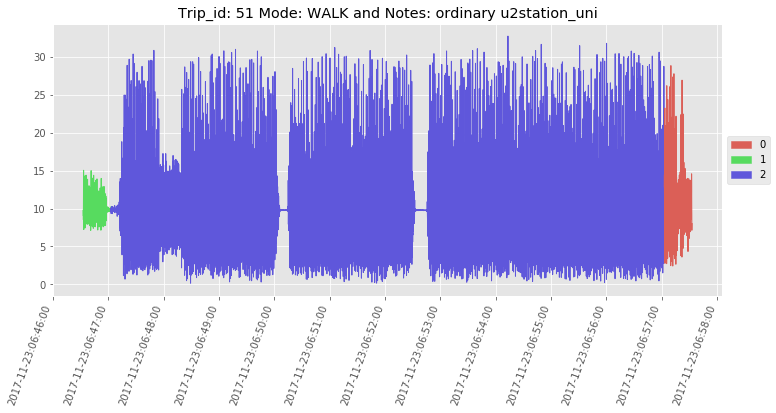

In [13]:
mode = trips_unpacked[selected_trip]["annotation"]["mode"][0]
notes = trips_unpacked[selected_trip]["annotation"]["notes"][0]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Trip_id: {} Mode: {} and Notes: {}".format(selected_trip, mode,notes))
plot_timeseries_clustering(acceleration_data_trip["time"],acceleration_data_trip["total"], acceleration_data_trip["cluster_labels"], ax=ax)

## Visualise Clustering on 2D - TSNE Plot:

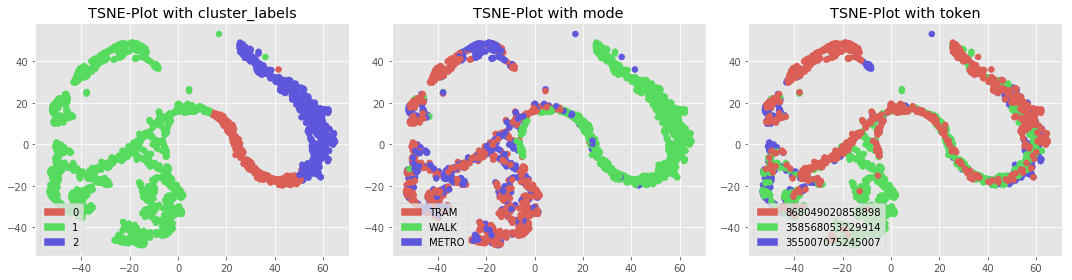

In [14]:
color_encodings = euclidean_distances.loc[:,["cluster_labels","mode","token"]]
plot_2D_tsne_with_coloring_per_targets(trips_only, color_encodings)

## Plot the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [15]:
def get_distribution_of_cluster_labels_for(target, distance_matrix):
    column_names = ["count_cluster_"+str(i) for i in np.sort(distance_matrix["cluster_labels"].unique())]
    column_names += [target]
    dist_df = pd.DataFrame(columns=column_names)
    # Collect cluster counts per mode
    for index, target_value in enumerate(distance_matrix[target].unique()):
        distance_per_target_value = distance_matrix[distance_matrix[target]==target_value]
        dist_df.loc[index,target]=target_value
        cluster_label_dist = distance_per_target_value.groupby("cluster_labels").count()[target]
        for cluster_id, label_count in cluster_label_dist.iteritems():
                dist_df.loc[index,"count_cluster_"+str(cluster_id)]=label_count

        dist_df.fillna(0,inplace=True)

    return dist_df

mode_dist_df = get_distribution_of_cluster_labels_for("mode", euclidean_distances)
mode_dist_df

count_cluster_0  count_cluster_1  count_cluster_2   mode
0             12.0            465.0              0.0  METRO
1            198.0             73.0            422.0   WALK
2              2.0            659.0              0.0   TRAM

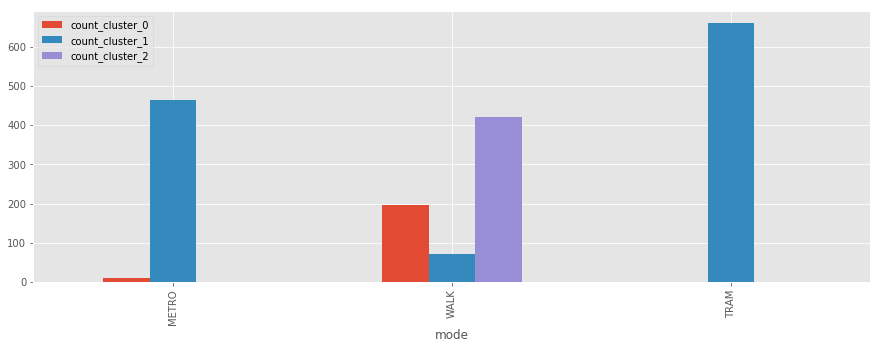

In [16]:
mode_dist_df.set_index("mode").plot(kind="bar",figsize=(15,5));

## Plot distribution of cluster labels for scripted and tokens

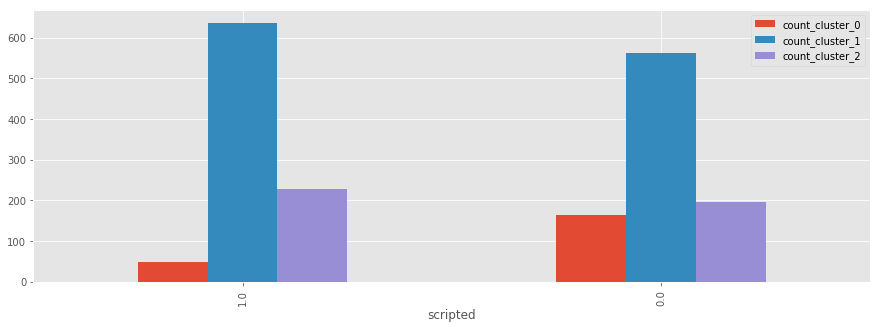

In [17]:
scripted_dist_df = get_distribution_of_cluster_labels_for("scripted", euclidean_distances)
scripted_dist_df.set_index("scripted").plot(kind="bar",figsize=(15,5));

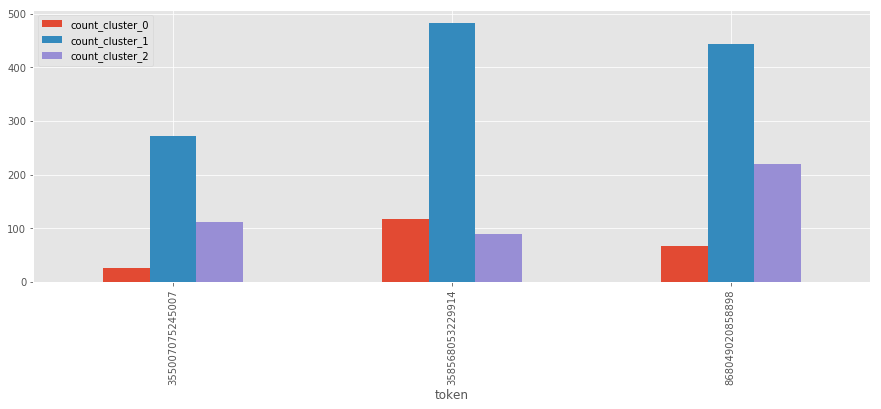

In [18]:
token_dist_df = get_distribution_of_cluster_labels_for("token", euclidean_distances)
token_dist_df.set_index("token").plot(kind="bar",figsize=(15,5));

## Plot all trips with their clustering labels

Produce this plot more conveniently by writing:

C:\Users\Lukas\.conda\envs\Tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



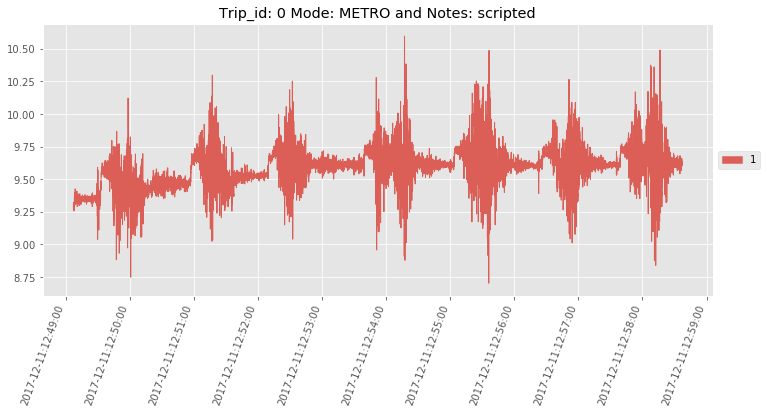

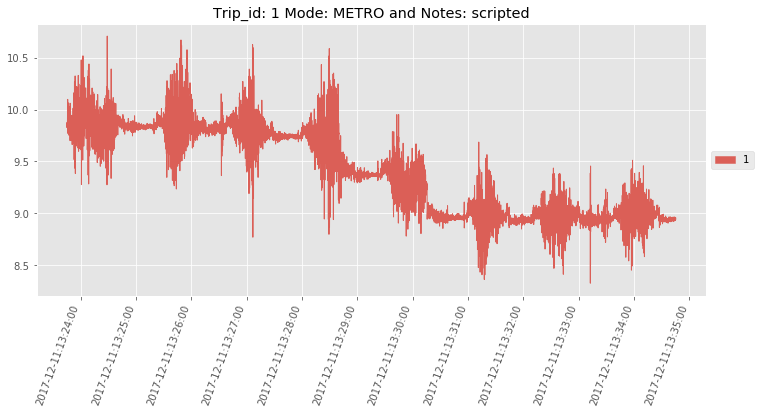

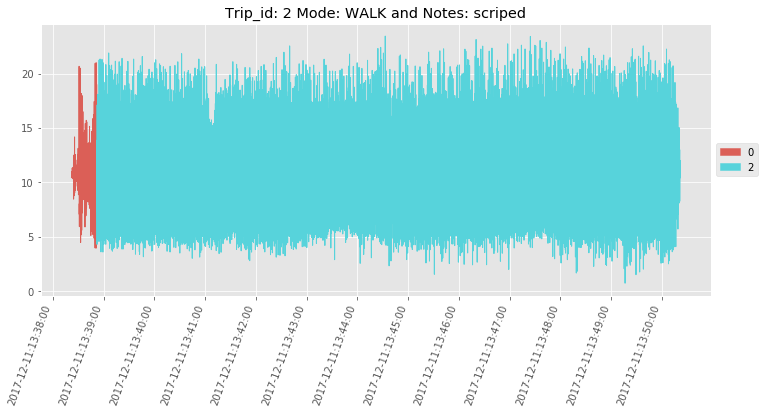

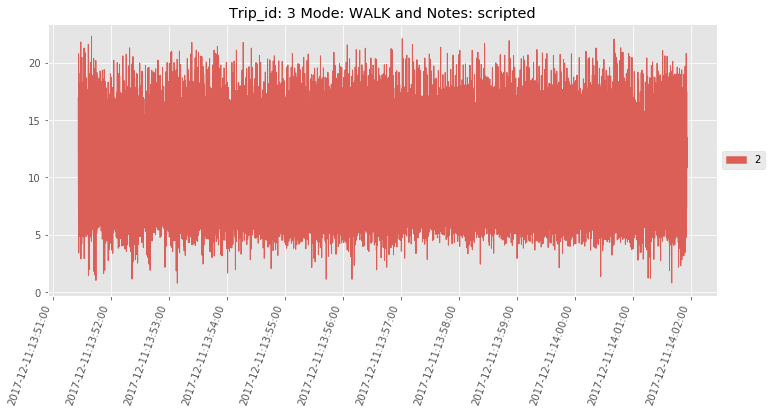

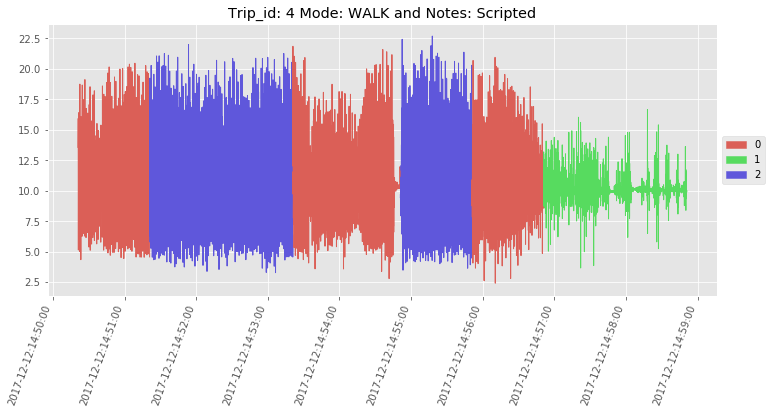

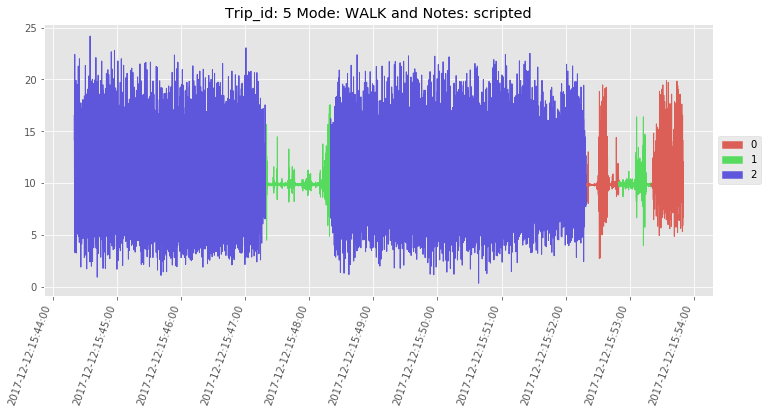

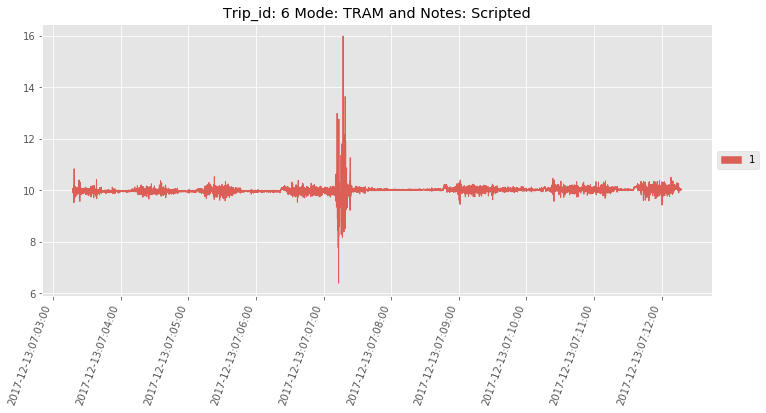

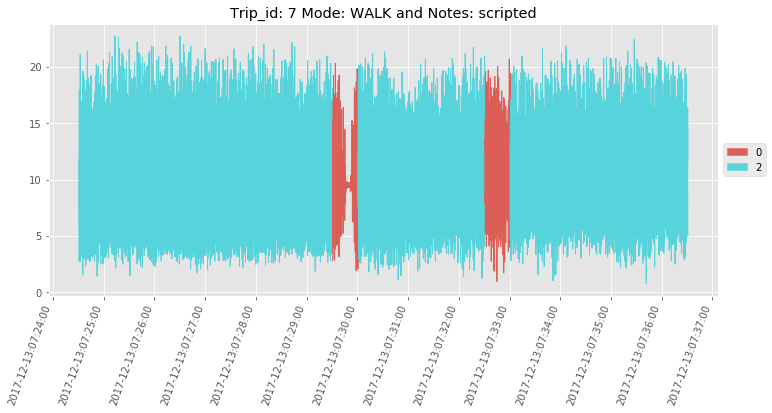

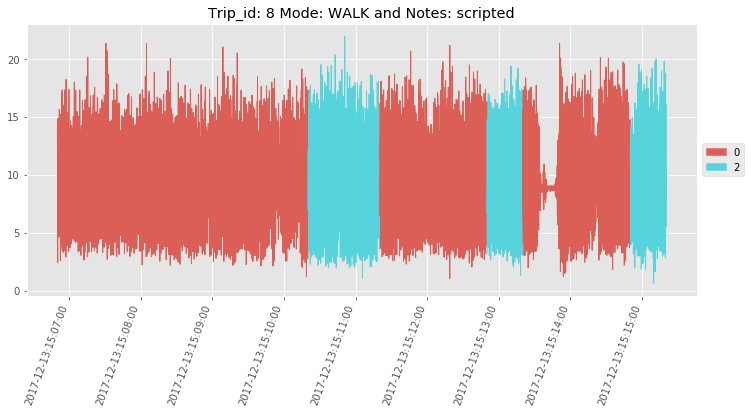

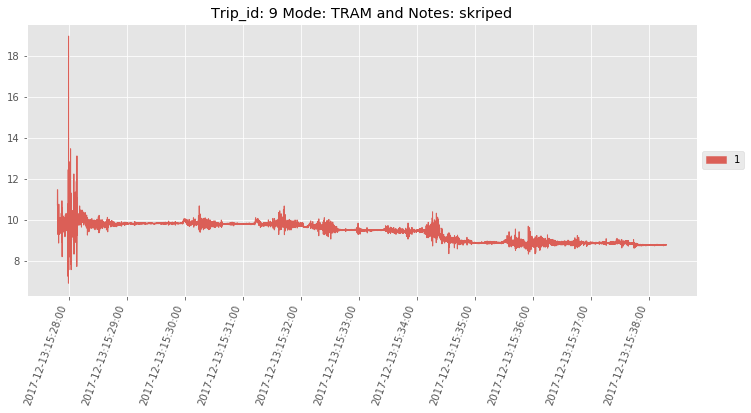

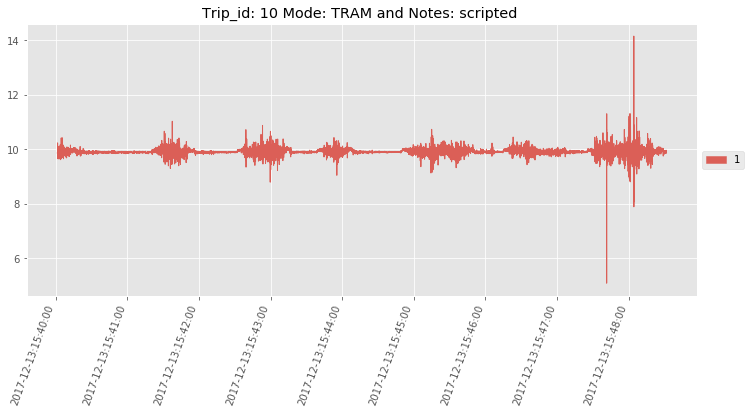

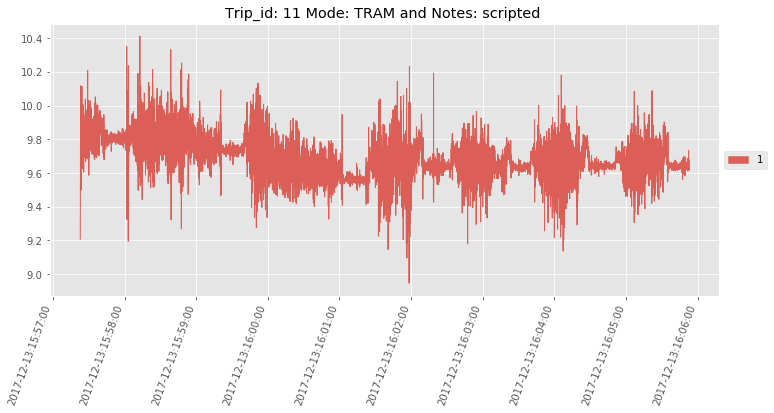

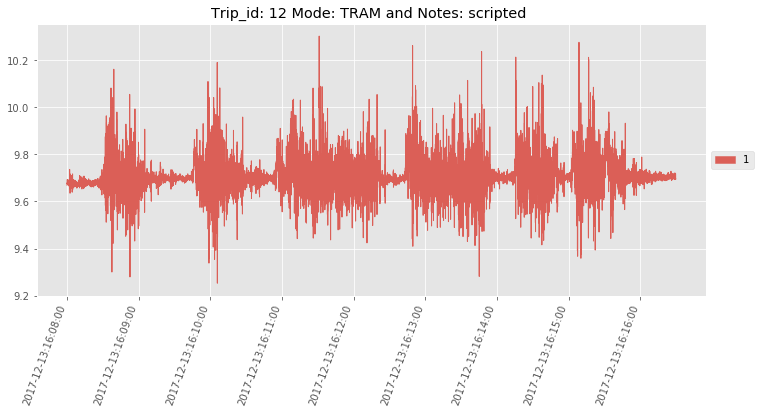

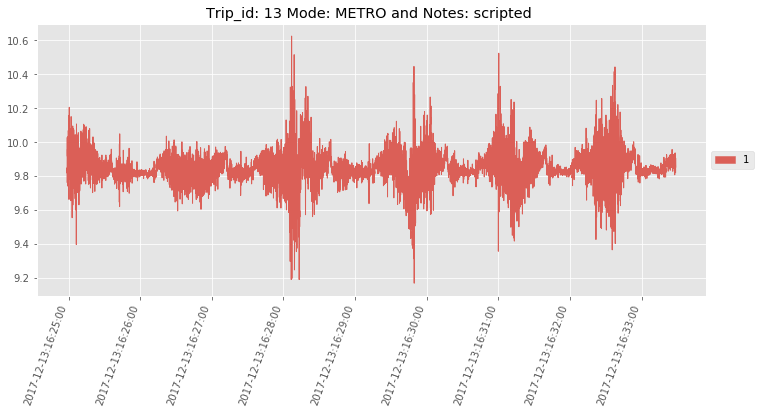

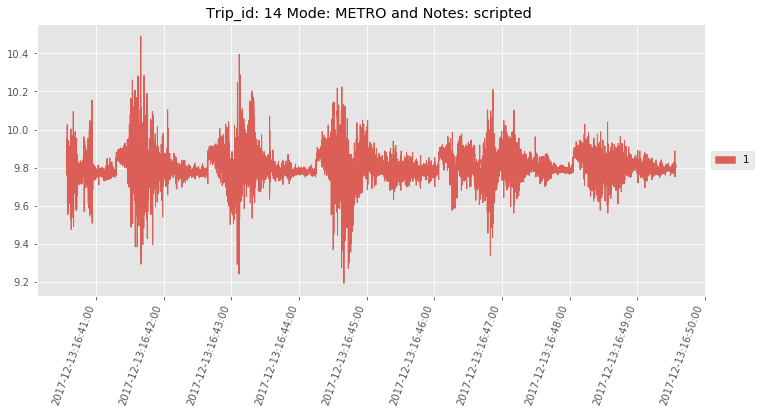

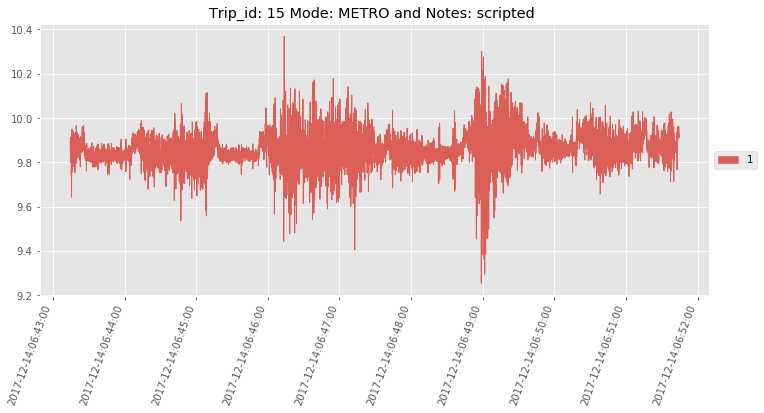

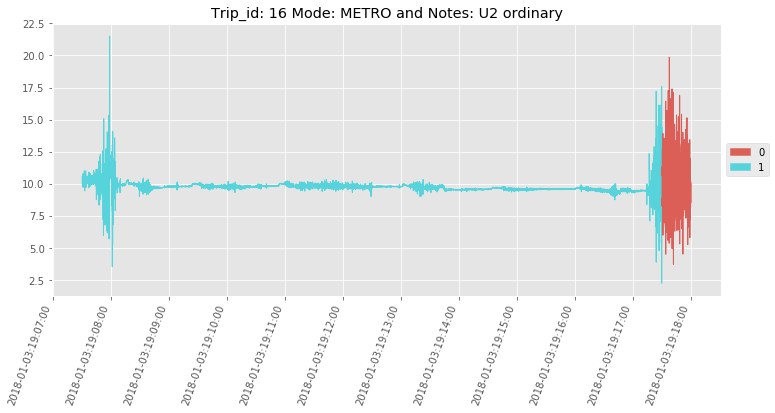

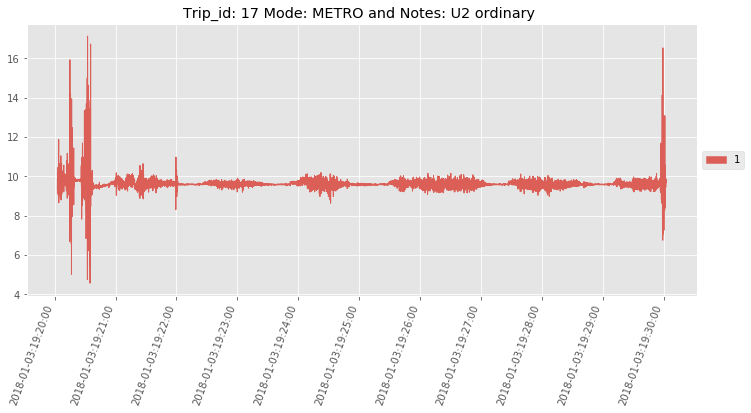

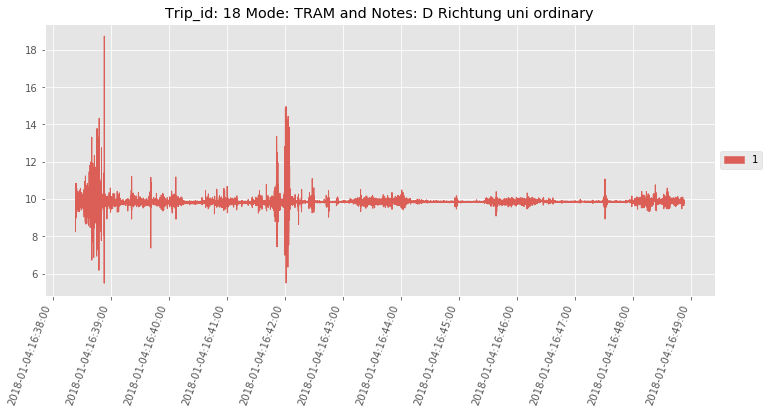

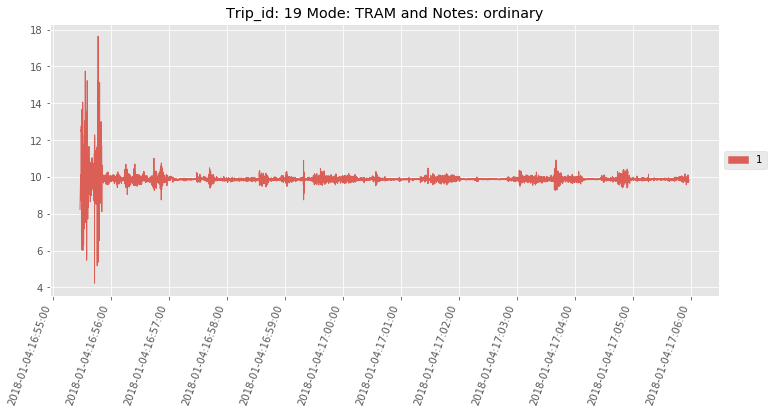

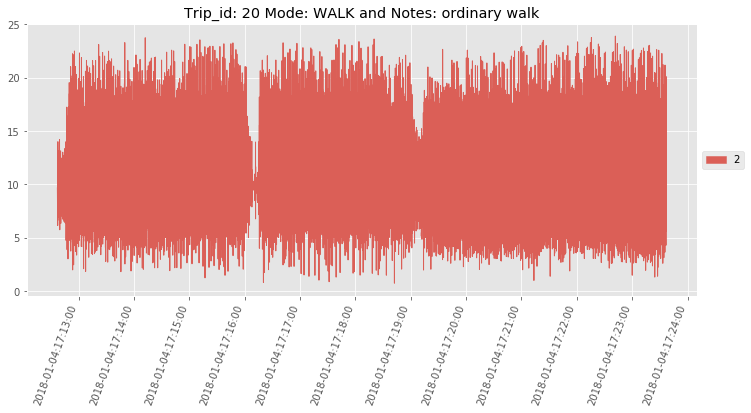

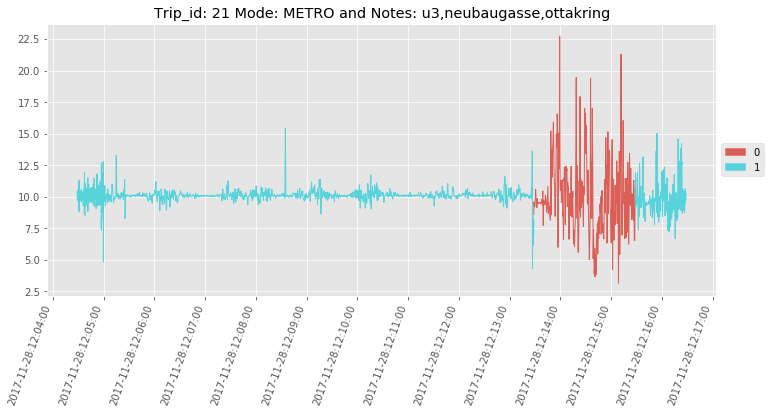

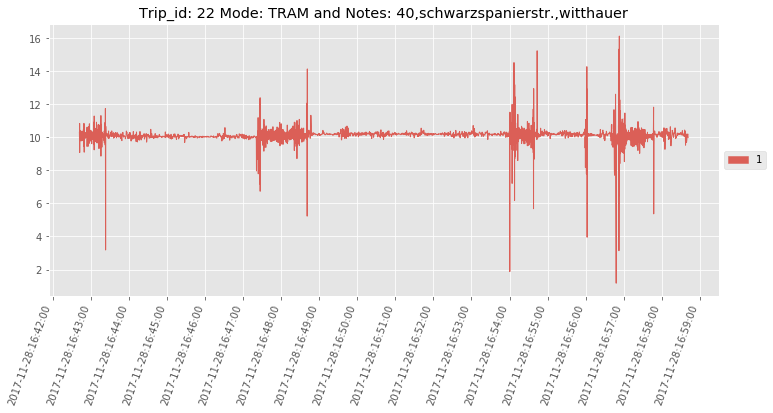

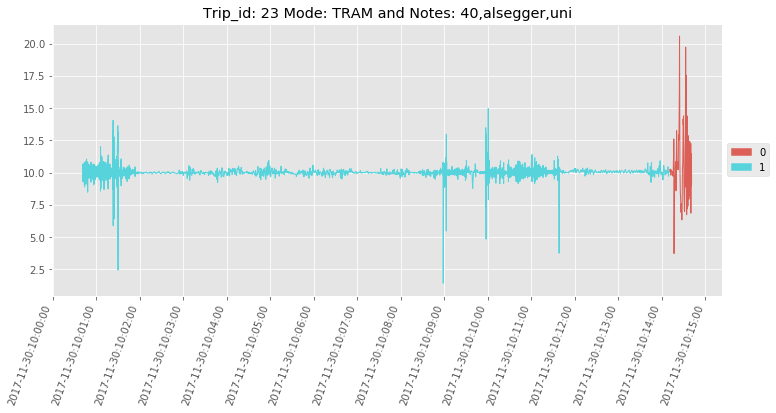

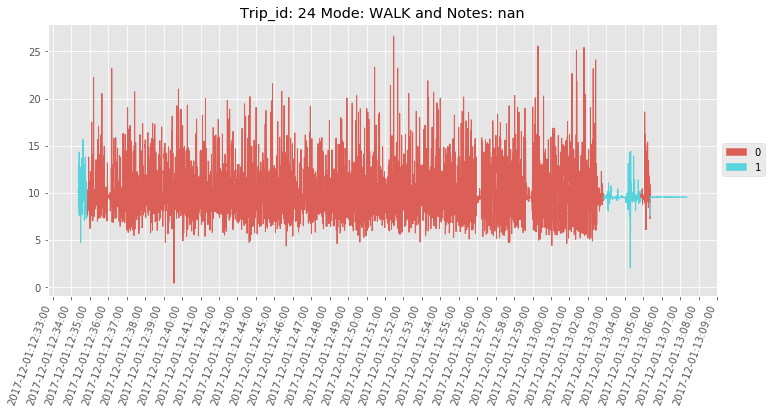

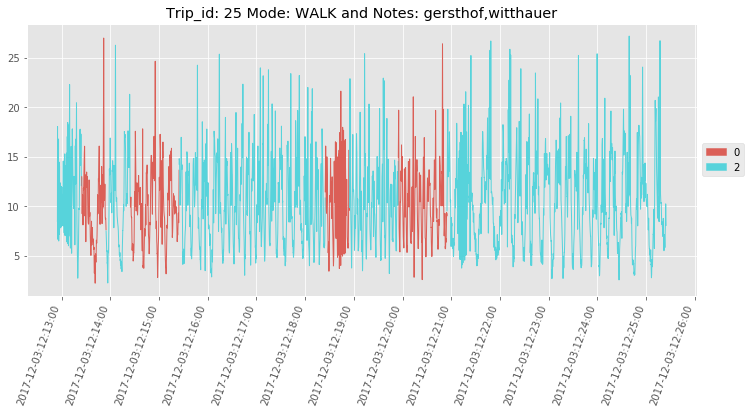

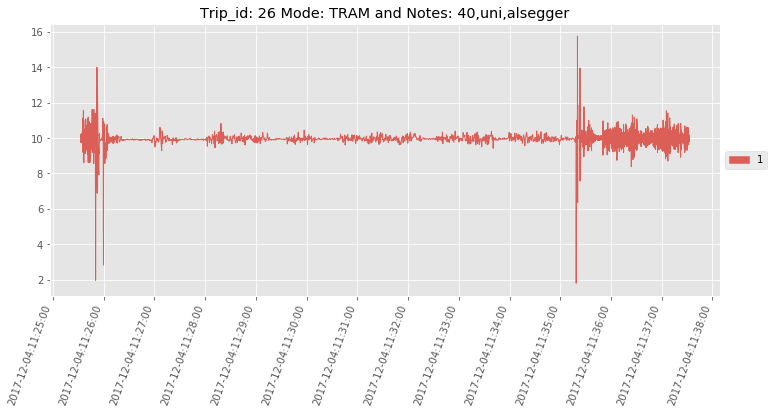

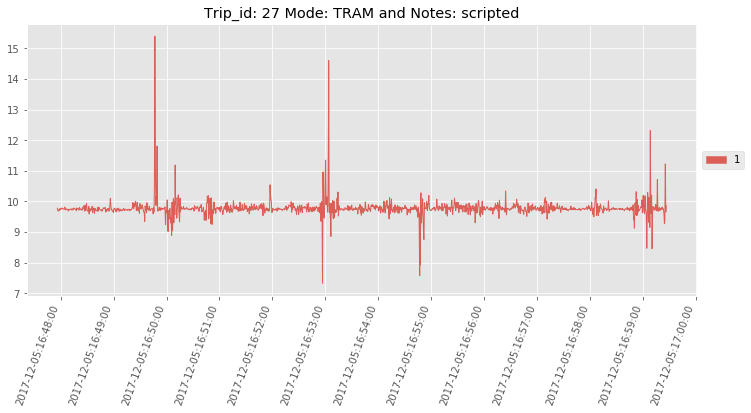

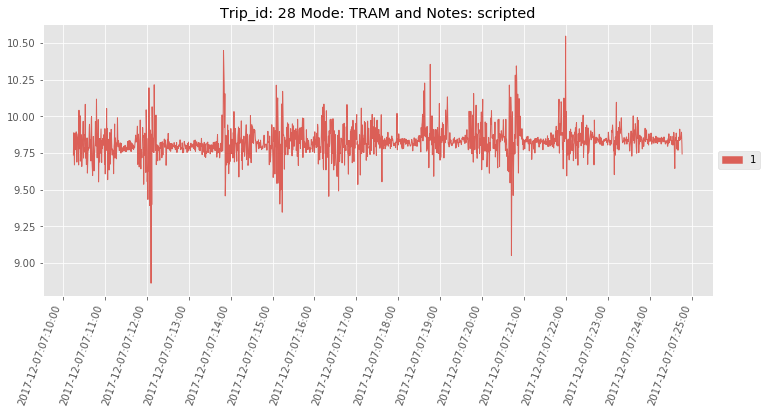

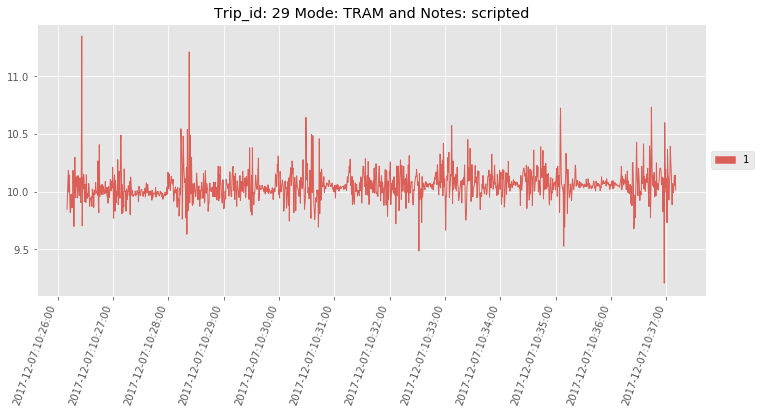

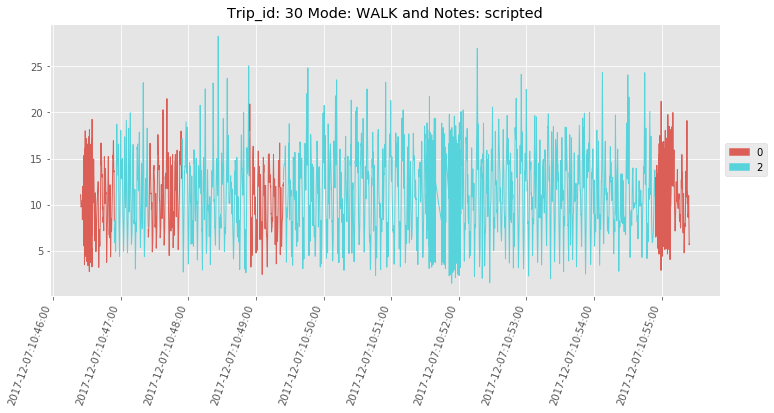

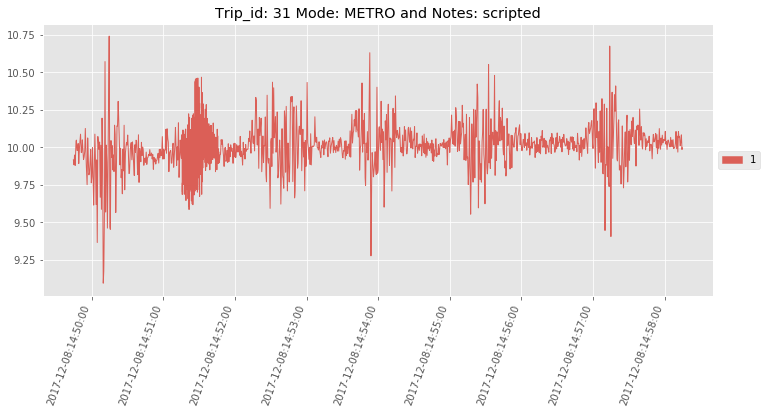

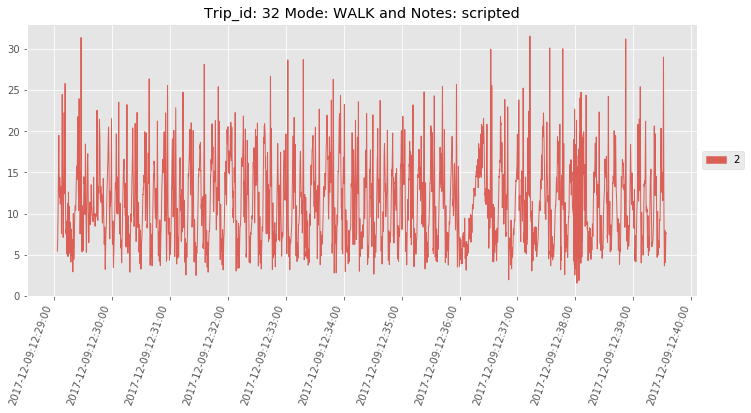

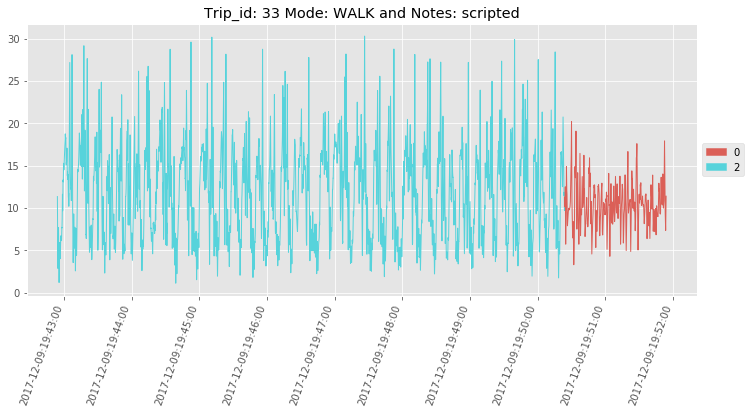

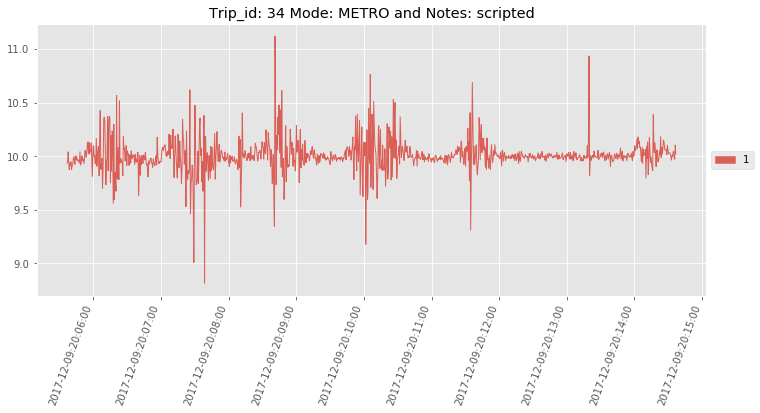

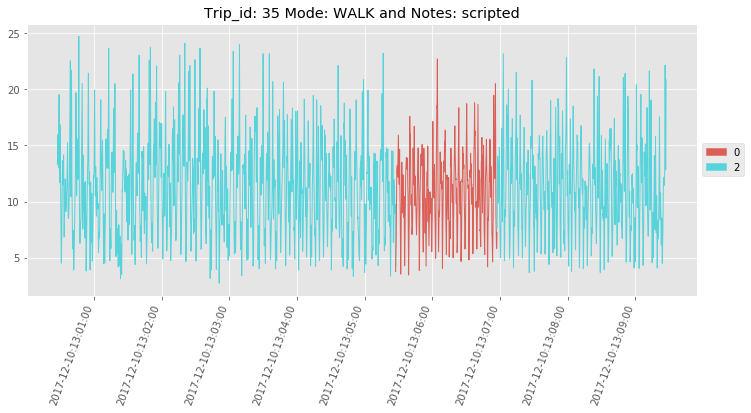

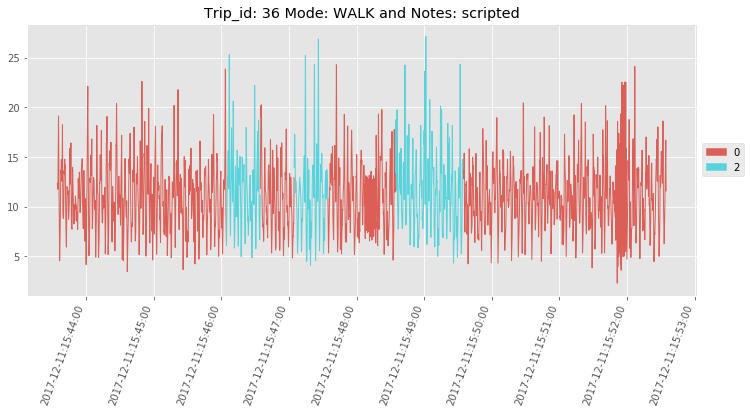

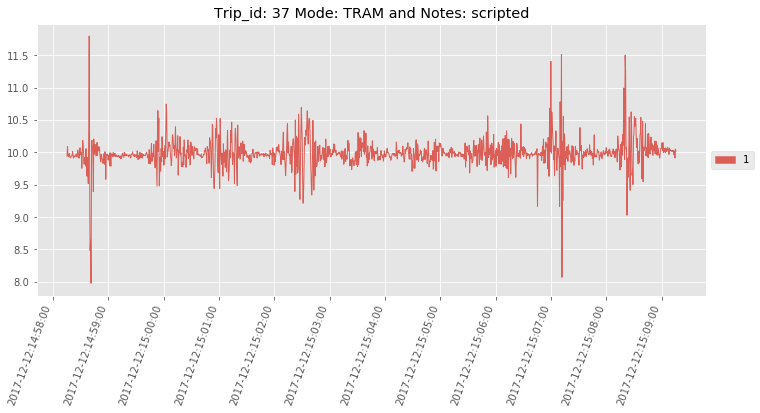

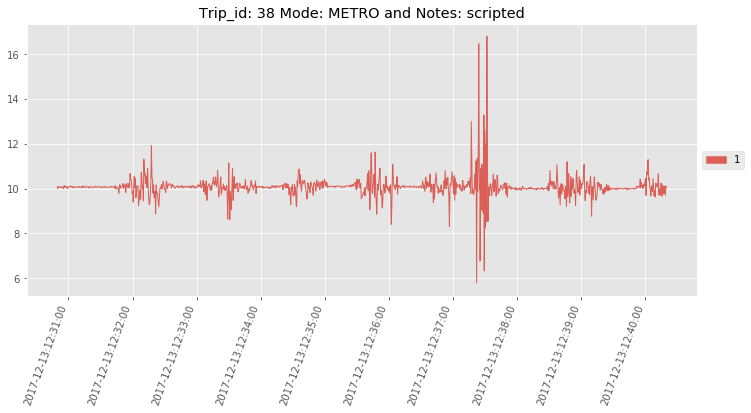

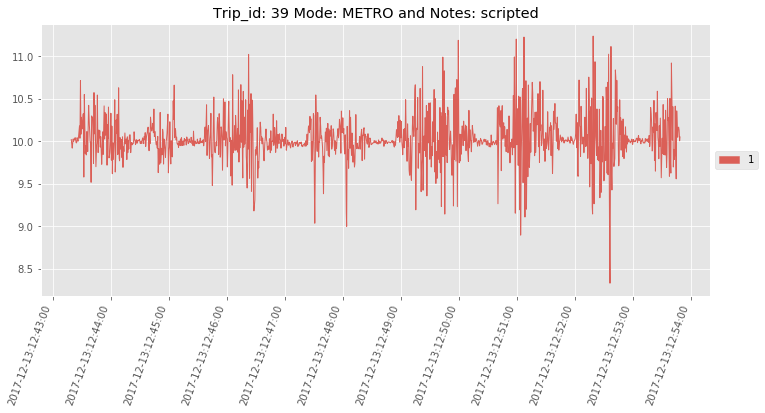

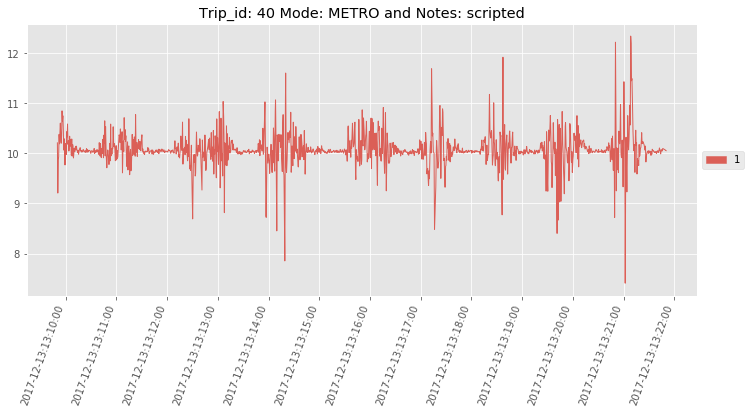

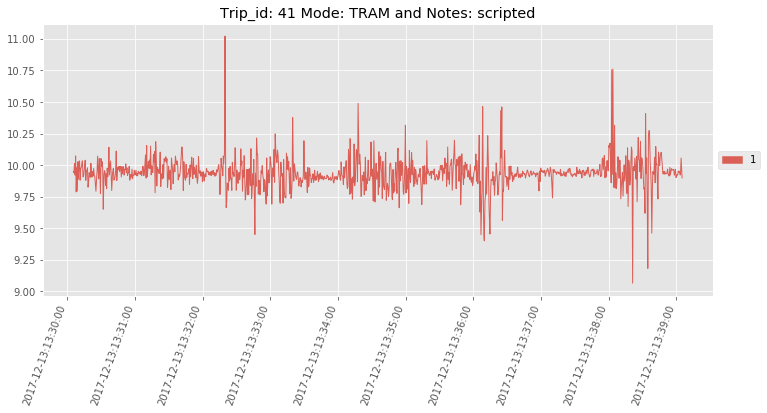

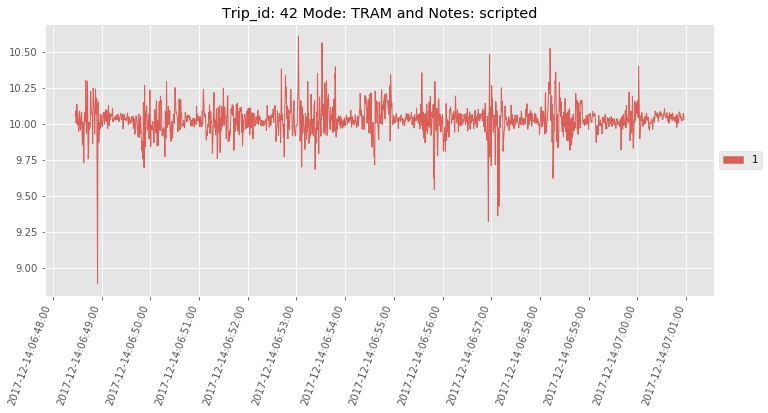

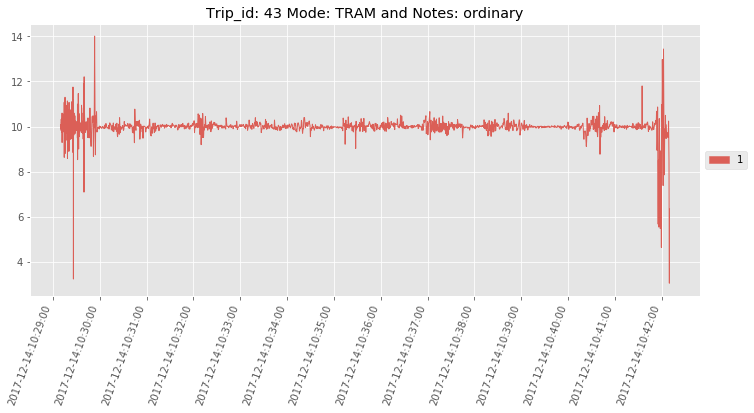

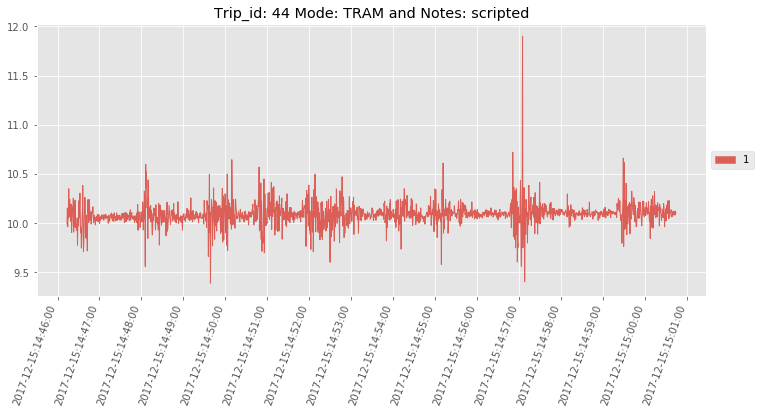

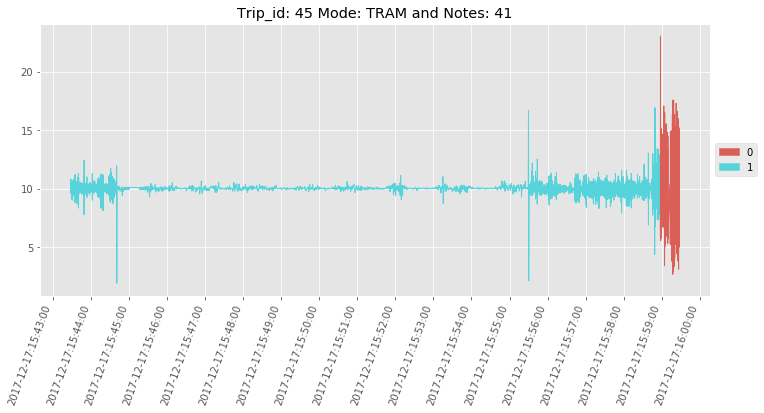

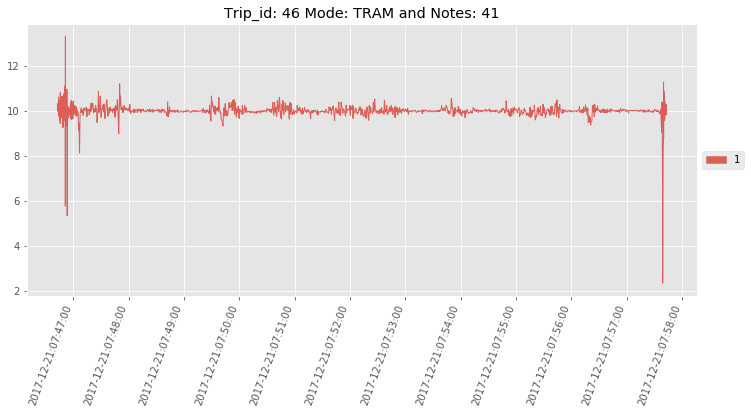

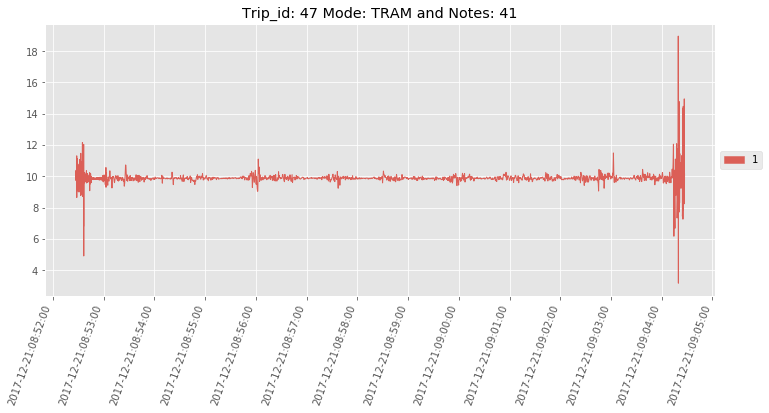

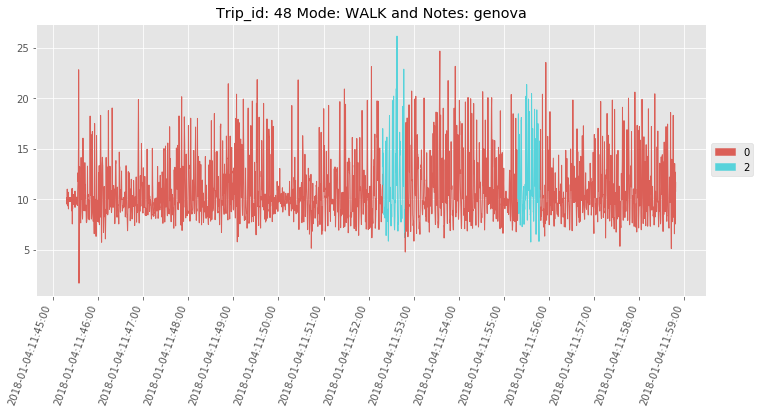

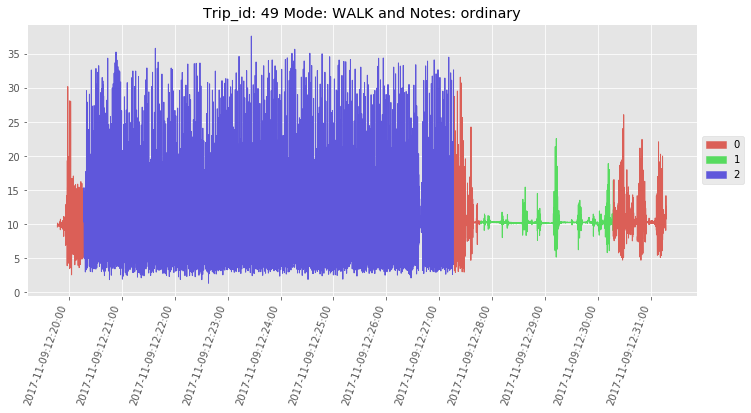

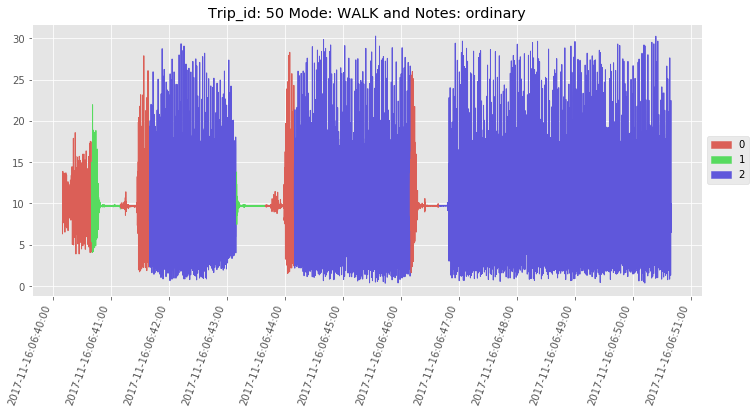

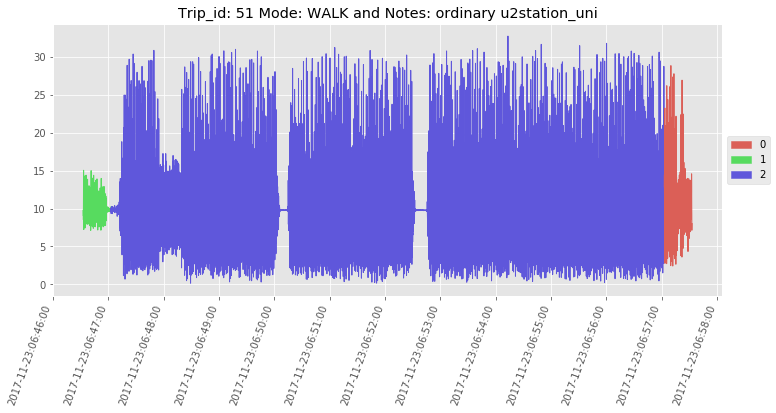

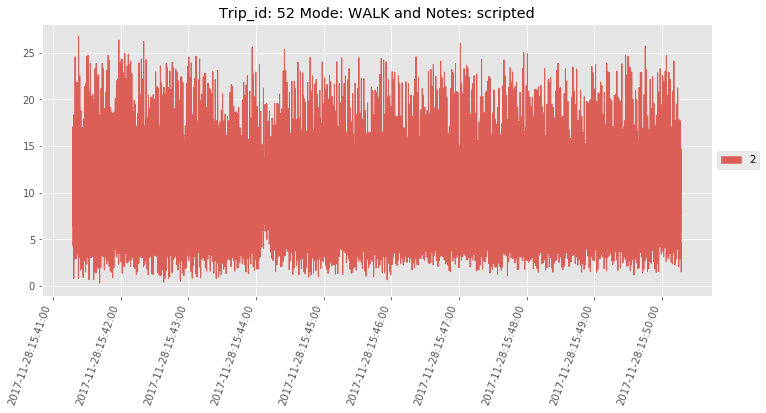

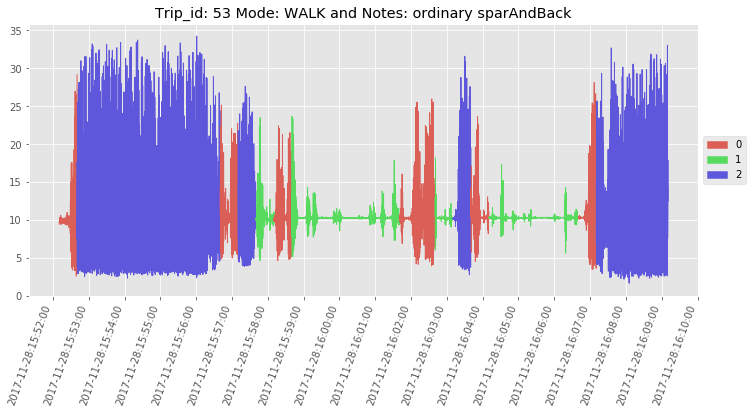

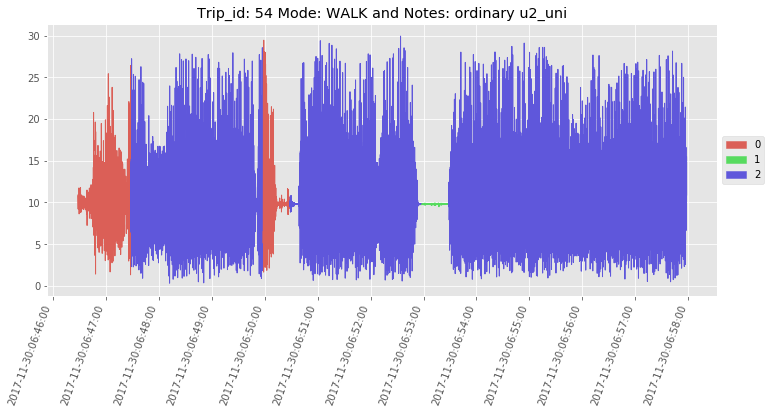

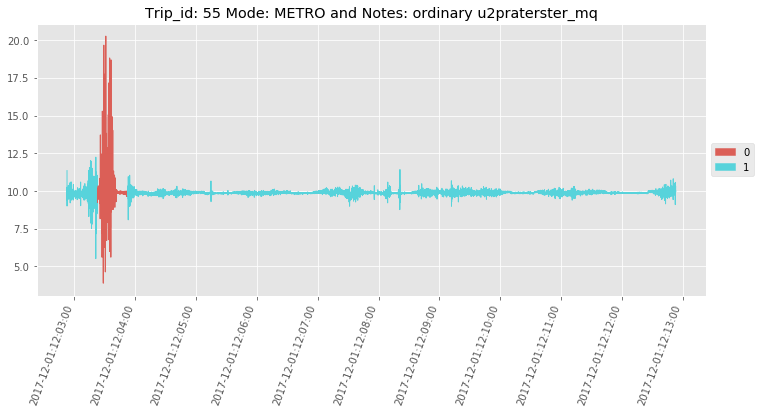

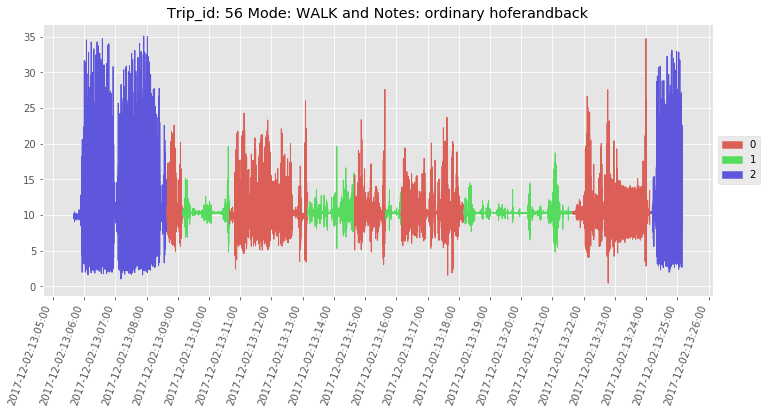

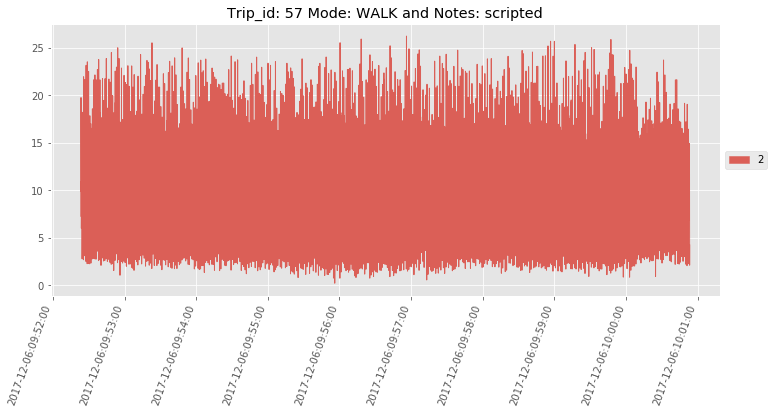

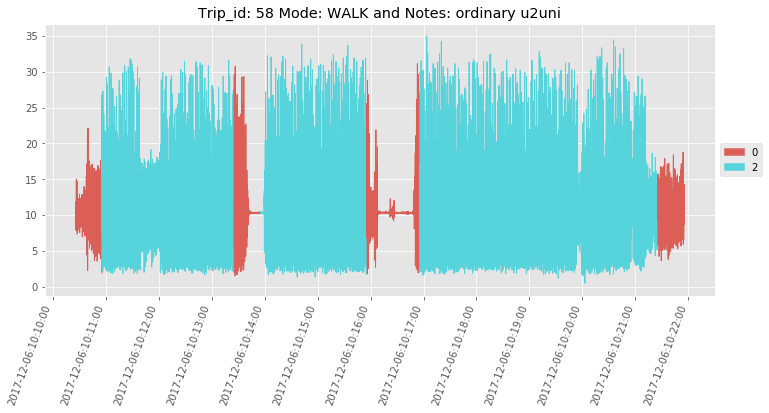

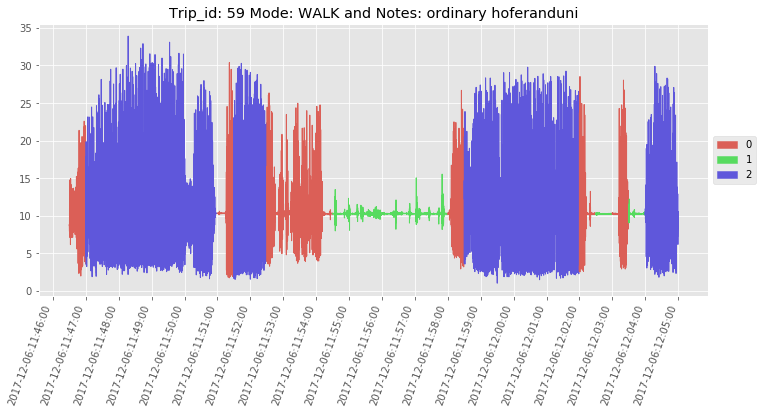

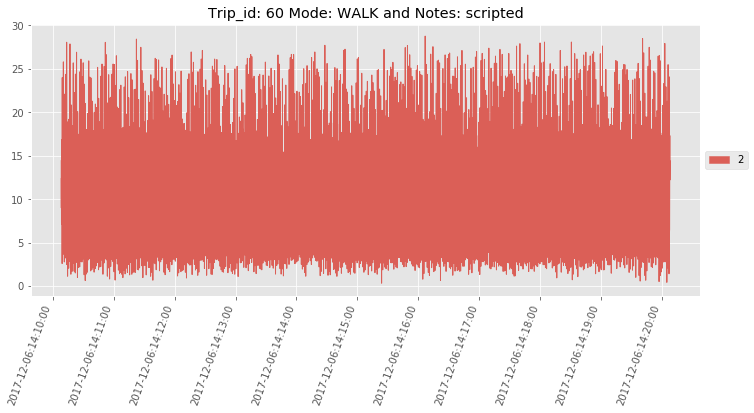

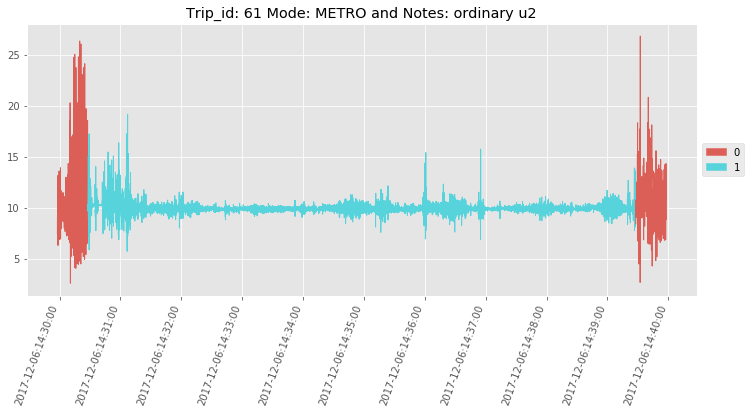

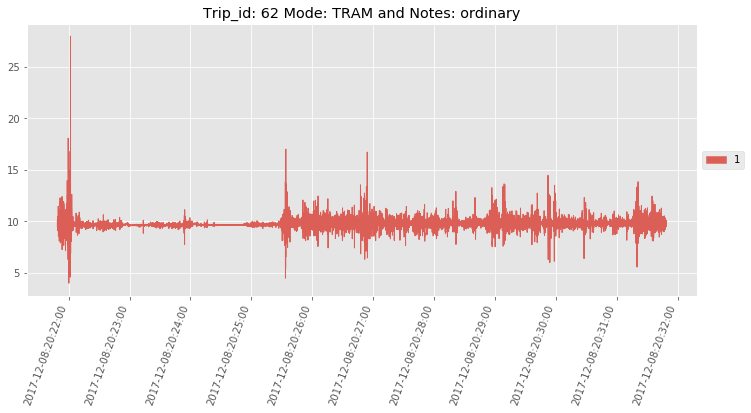

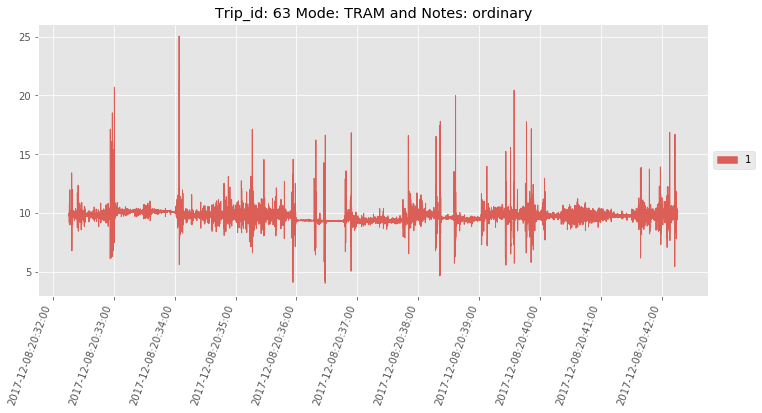

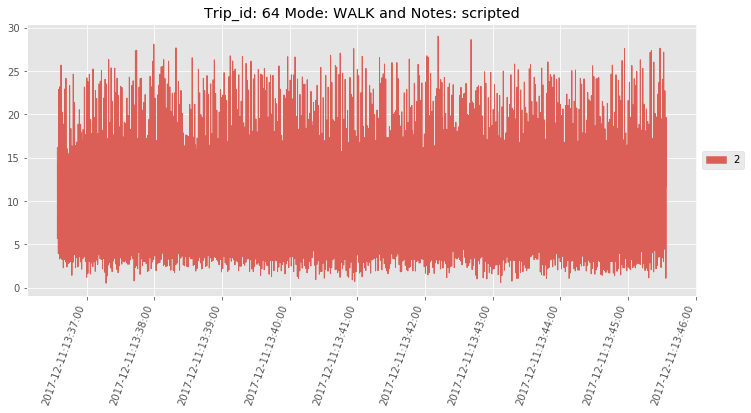

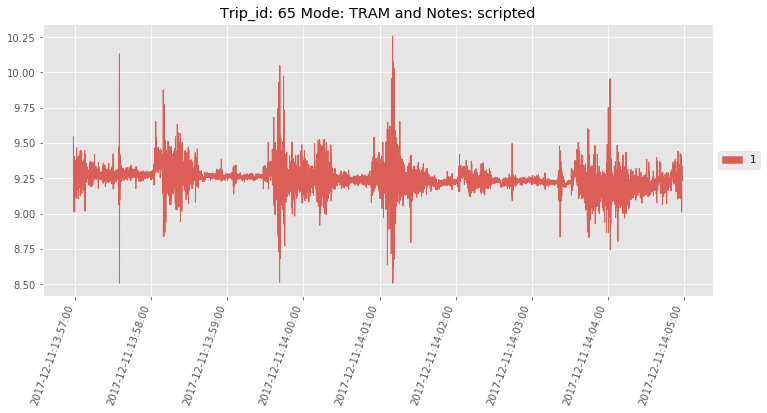

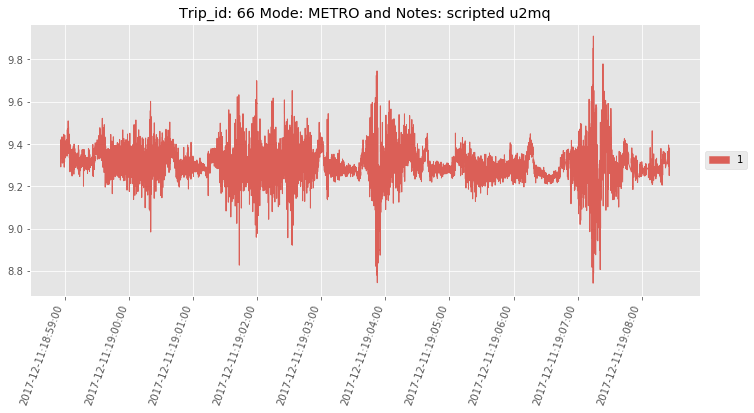

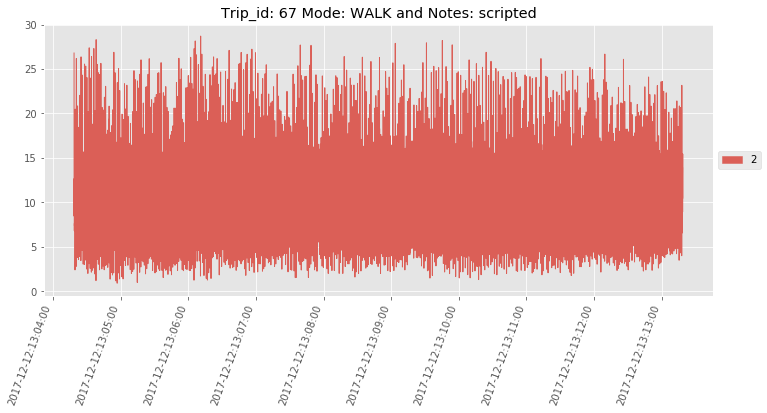

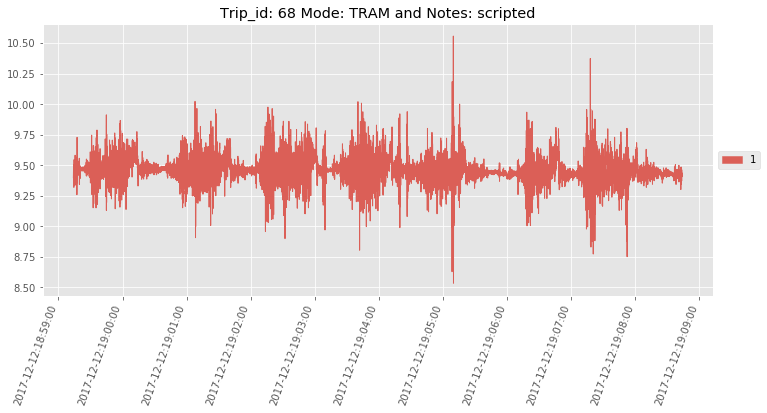

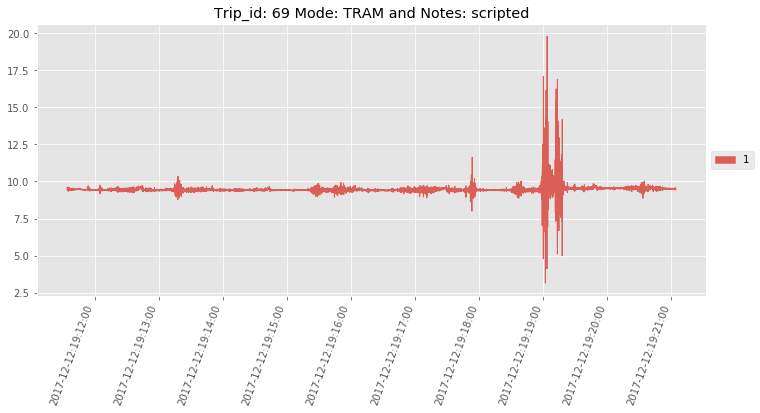

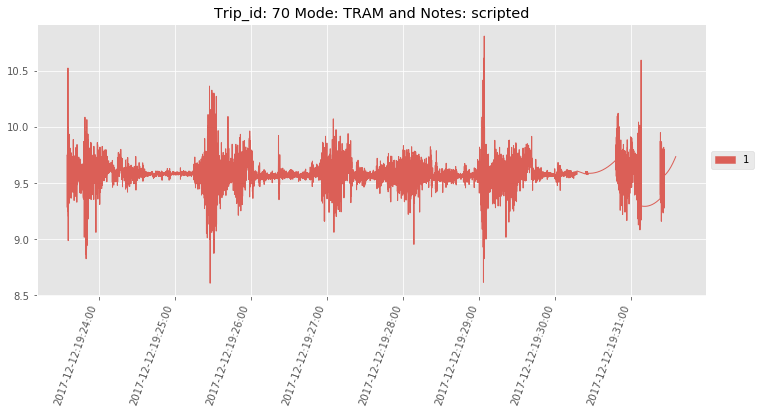

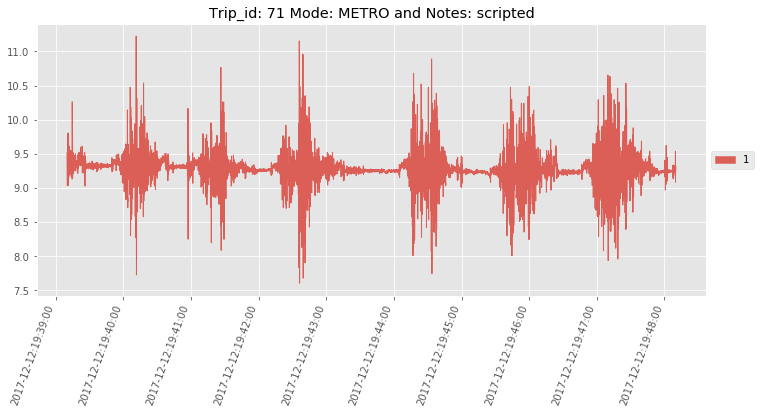

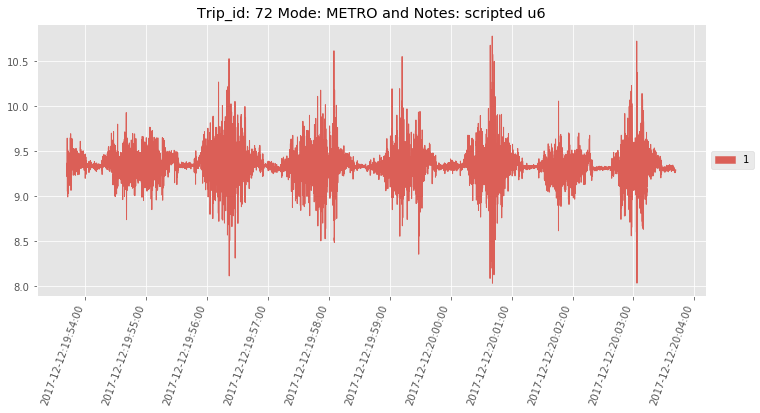

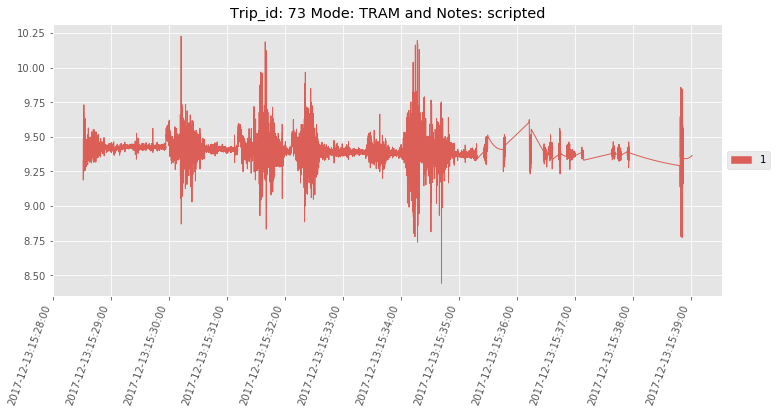

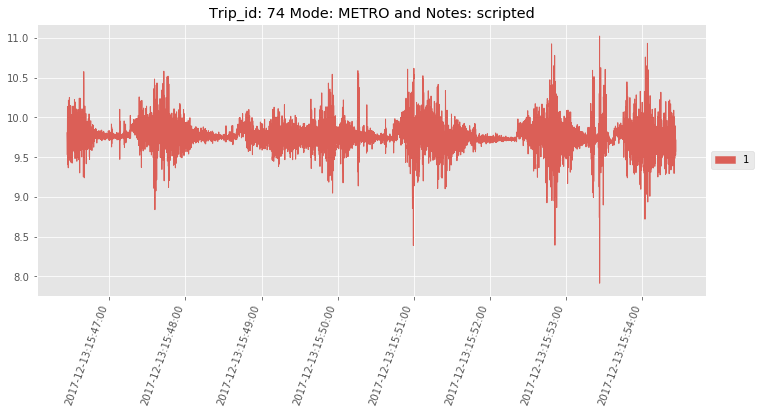

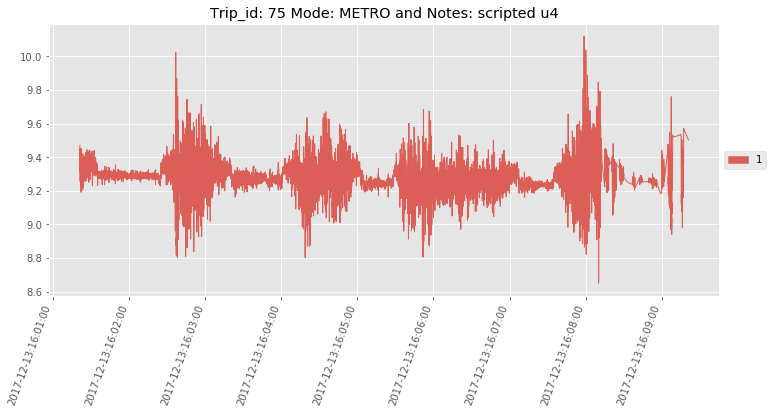

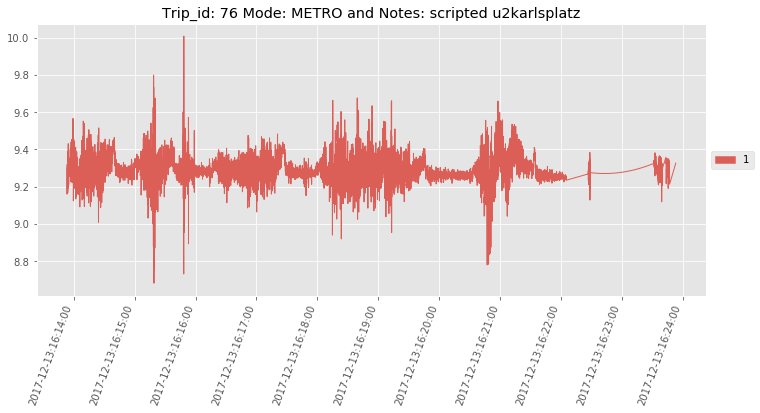

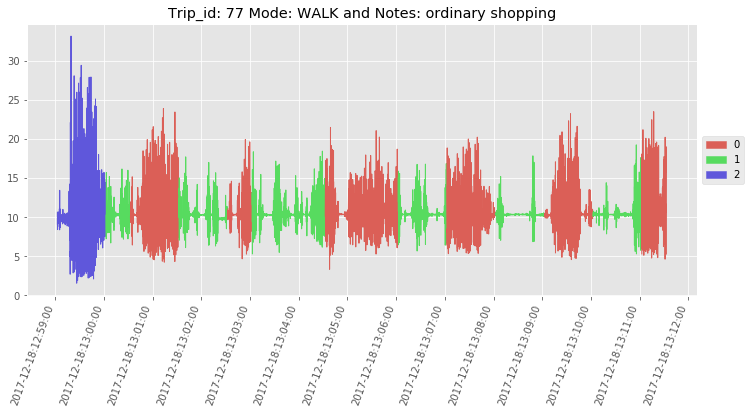

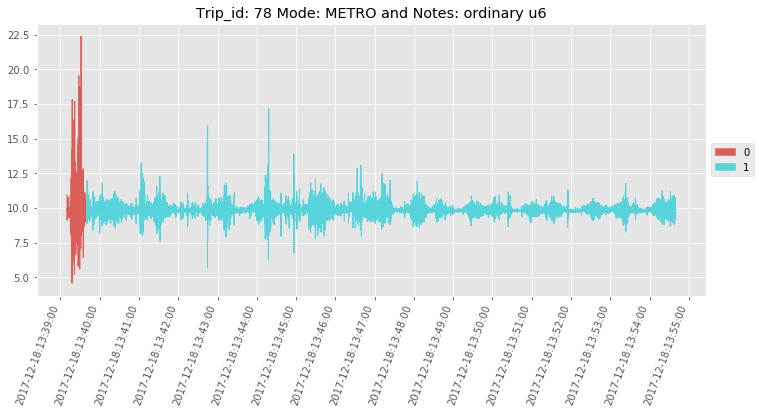

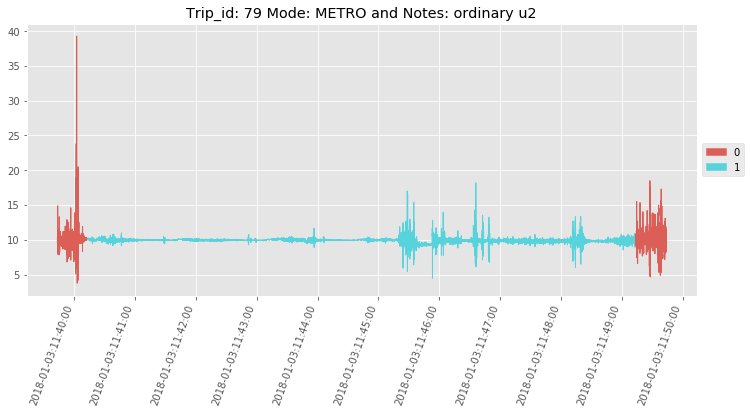

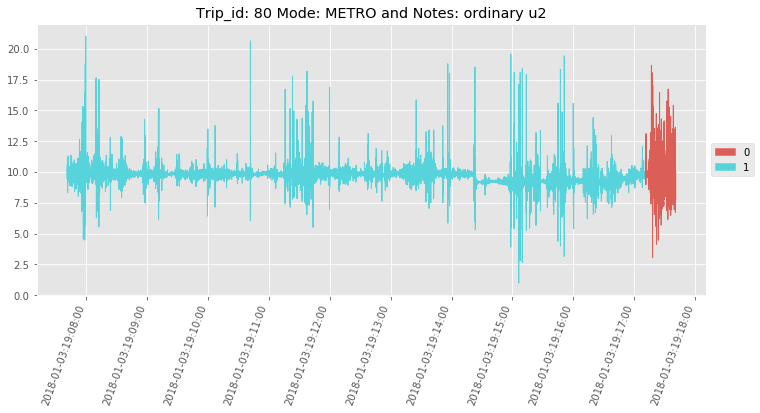

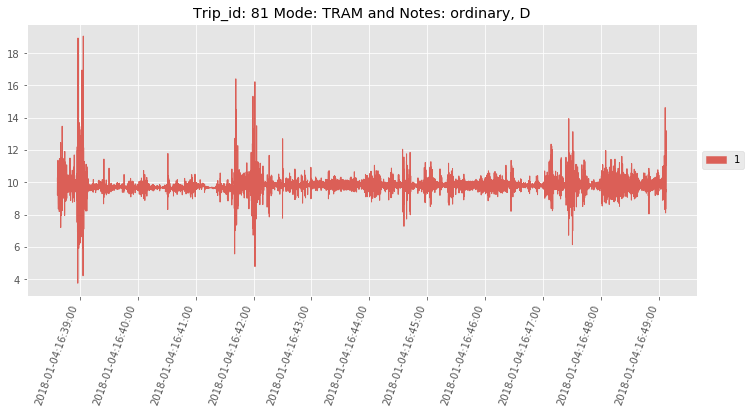

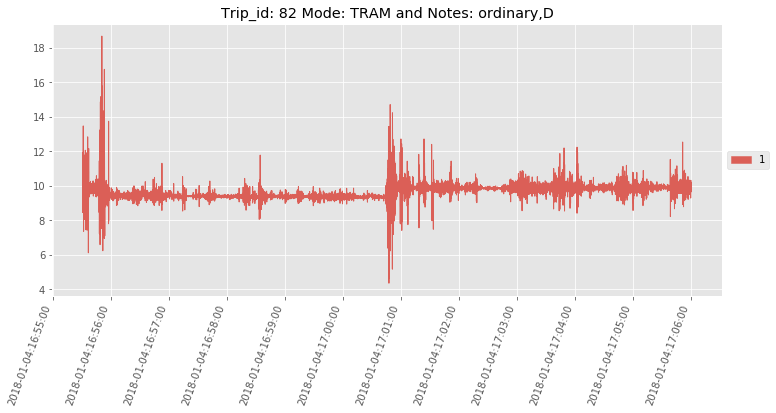

In [19]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    plot_all_trips_with_cluster_coloring(trips_unpacked, euclidean_distances)